Primera notebook de una serie de tutoriales sobre Computer Vision.

Los modelos serán principalmente construidos desde Keras con CNNs. No van a ser tutoriales muy teóricos.

Este notebook abarca:
+ [Carga de datasets desde keras](#one).
+ [Visualización de imágenes, reshapes correspondientes](#two).
+ [Modelo de keras convolucionales](#three).
+ Visualización curva de loss.
+ [Data augmentacion](#four) con generador de keras.
+ Visualización de resultados: [Confusion Matrix, visualización de errores](#five).
+ [Interpretación de predicciones](#six)

# <font color="#9E1B32">¿Qué puede hacer Computer Vision?
<img src="./Images/Que es que en CV.png">

Clasificación en CV indica si detectamos lo que estemos buscando o no en la imagen. Puede ser un objeto, un animal, un tumor... 
+ Puede ser binaria: gato/perro o gato/no gato.
+ Puede ser detección de múltiples cosas. Hay modelos que detectan de manera eficaz más de mil objetos distintos.

La clasificación puede ser combinada con la localización del objeto. Tanto con un único objeto como múltiples. 

Otro tipo de detecteción es la segmentación, en la cual en vez de en un cuadrado detectamos los bordes del objeto.

# <font color="#9E1B32">MNIST

Mnist es el "Hello World" de Computer Vision. Dígitos escritos a manos de tamaño 28x28 en blanco y negro. El objetivo es clasificarlos con una red neuronal convolucional.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
#Evita que tengamos que preocuparnos de añadir plt.show() en cada celda
%matplotlib inline

np.random.seed(2) #Semilla para obtener los mismo resultados

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau #Reduce learning rate when a metric has stopped improving.

sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


### <font color="#9E1B32">Carga datos <a class="anchor" id="one"></a>

In [20]:
from keras.datasets import mnist 
(x_train, y_train), (x_test, y_test) = mnist.load_data()

0


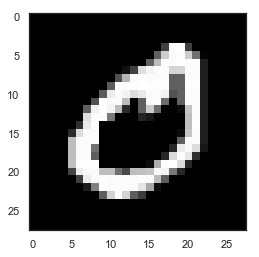

In [29]:
image_index = 21
print(y_train[image_index]) 
plt.imshow(x_train[image_index], cmap='gray')

In [30]:
x_train.shape, x_test.shape, x_train[0]

((60000, 28, 28),
 (10000, 28, 28),
 array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          18,  18,  18, 126, 136, 175,  26, 166, 2

Los datos son enteros entre 0, 255. Necesitamos reescalarlos.

### <font color="#9E1B32">Resizes <a class="anchor" id="two"></a>

In [32]:
# Necesitamos añadir una cuarta dimension para que funcione bien con keras.
#RGB imágenes, tienen 3 canales, hubiésemos hecho reshape a 28x28x3.
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Lo pasamos a decimales para evitar problemas al dividir  
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Dividimos entre el máximo valor de un pixel.
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Número de imágenes en x_train', x_train.shape[0])
print('Número de imágenes en x_test', x_test.shape[0])

x_train shape: (60000, 28, 28, 1)
Número de imágenes en x_train 60000
Número de imágenes en x_test 10000


Las clases están balanceadas

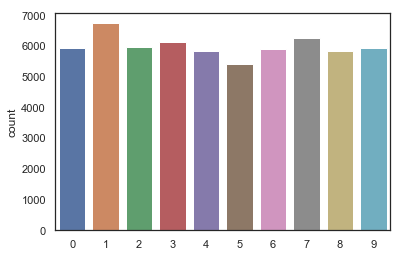

In [37]:
sns.countplot(y_train)

## <font color="#9E1B32">One hot encoding

In [41]:
y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

# <font color="#9E1B32">Modelo  <a class="anchor" id="three"></a>

En este ejemplo no vamos a usar Validation Set.

Veamos dos modelos. El primero una red neuronal usando Sequential de Keras. Consiste en 2 capas convolucionales con max pooling y dropout.

In [56]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

input_shape = (28,28,1)

model = Sequential()

model.add(Conv2D(filters = 28, kernel_size = (5,5), input_shape = input_shape, activation ='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters = 28, kernel_size = (3,3), input_shape = input_shape, activation ='relu'))

model.add(MaxPooling2D(pool_size = (2, 2)))
 
model.add(Flatten()) #necesitamos pasarlo los datos a un vector de 1 dimesioón antes de ir a una capa densa.

model.add(Dense(128, activation = 'relu'))

model.add(Dropout(0.2))

model.add(Dense(10,activation = 'softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [57]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
hcall = LossHistory()

In [58]:
model.fit(x=x_train,y=y_train, batch_size=256, epochs=20,callbacks=[hcall],verbose=1)

Epoch 1/20
60000/60000 [==============================] - 27s 449us/step - loss: 1.2812 - acc: 0.5895
Epoch 2/20
60000/60000 [==============================] - 26s 433us/step - loss: 0.4438 - acc: 0.8614
Epoch 3/20
60000/60000 [==============================] - 27s 458us/step - loss: 0.3400 - acc: 0.8936
Epoch 4/20
60000/60000 [==============================] - 27s 447us/step - loss: 0.2782 - acc: 0.9137
Epoch 5/20
60000/60000 [==============================] - 27s 450us/step - loss: 0.2316 - acc: 0.9284
Epoch 6/20
60000/60000 [==============================] - 26s 438us/step - loss: 0.1995 - acc: 0.9382
Epoch 7/20
60000/60000 [==============================] - 26s 434us/step - loss: 0.1763 - acc: 0.9452
Epoch 8/20
60000/60000 [==============================] - 26s 435us/step - loss: 0.1563 - acc: 0.9516
Epoch 9/20
60000/60000 [==============================] - 26s 438us/step - loss: 0.1401 - acc: 0.9564
Epoch 10/20
60000/60000 [==============================] - 26s 438us/step - loss: 

Obtenemos un Accuracy muy elevado tanto en train como en test.

In [59]:
model.evaluate(x_train, y_train), model.evaluate(x_test, y_test)

10000/10000 [==============================] - 2s 153us/step


([0.047177124196259926, 0.9855666666666667], [0.050602179957320914, 0.9842])

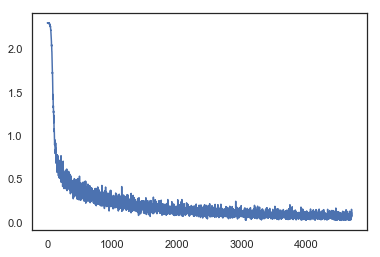

In [60]:
plt.plot(hcall.losses)
plt.show()

In [69]:
preds=model.predict_classes(x_test)
A=[i for i in range(len(y_test)) if np.argmax(y_test, axis=1)[i]!=preds[i]]
print("Se equivoca",len(A),"veces.")

Se equivoca 158 veces.


3


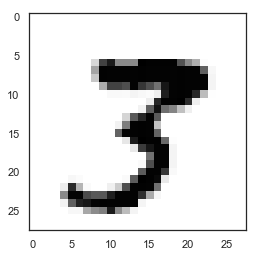

In [61]:
image_index = np.random.randint(0,10000)
plt.imshow(x_test[image_index].reshape(28, 28),cmap='Greys')
pred = model.predict(x_test[image_index].reshape(1, 28, 28, 1))
print(pred.argmax())

# <font color="#9E1B32">Data Augmentacion <a class="anchor" id="four"></a>

Vamos a aplicar data augmentacion a nuestros datos y a incluir una reducción de learning rate según la mejora de accuracy se reduce.

Para realizar data augmentacion vamos a usar un iterador de keras. En el siguiente ejemplo vamos a girar 10 grados al azar las imágenes, cambiar el rango de anchura y altura, y aplicar zoom.

Esto solo debe ser entrenado en el train. Las transformaciones siempre se entrenan únicamente en el train.

In [82]:
#Mismo modelo
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

input_shape = (28,28,1)

model = Sequential()

model.add(Conv2D(filters = 28, kernel_size = (5,5), input_shape = input_shape, activation ='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters = 28, kernel_size = (3,3), input_shape = input_shape, activation ='relu'))

model.add(MaxPooling2D(pool_size = (2, 2)))
 
model.add(Flatten()) #necesitamos pasarlo los datos a un vector de 1 dimesioón antes de ir a una capa densa.

model.add(Dense(128, activation = 'relu'))

model.add(Dropout(0.2))

model.add(Dense(10,activation = 'softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [2]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

Aquí aplicamos que el learning rate decaiga por un factor de 0.5 cada 3 "entrenamientos" que el accuracy no mejore.

In [84]:
learning_rate_reduction = ReduceLROnPlateau(monitor='loss',patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [85]:
%%time
# Entrenamos a la vez que realizamos el data augmentacion:
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=256),
                              epochs = 20,
                              verbose = 1, steps_per_epoch = x_train.shape[0] // 256,
                              callbacks=[learning_rate_reduction])

Epoch 1/20
234/234 [==============================] - 32s 138ms/step - loss: 1.9235 - acc: 0.3164
Epoch 2/20
234/234 [==============================] - 37s 159ms/step - loss: 1.1639 - acc: 0.6112
Epoch 3/20
234/234 [==============================] - 36s 155ms/step - loss: 0.9469 - acc: 0.6899
Epoch 4/20
234/234 [==============================] - 36s 155ms/step - loss: 0.7620 - acc: 0.7560
Epoch 5/20
234/234 [==============================] - 41s 175ms/step - loss: 0.6413 - acc: 0.7965
Epoch 6/20
234/234 [==============================] - 39s 165ms/step - loss: 0.5598 - acc: 0.8239
Epoch 7/20
234/234 [==============================] - 39s 167ms/step - loss: 0.4930 - acc: 0.8449
Epoch 8/20
234/234 [==============================] - 37s 160ms/step - loss: 0.4435 - acc: 0.8635
Epoch 9/20
234/234 [==============================] - 37s 156ms/step - loss: 0.4040 - acc: 0.8738
Epoch 10/20
234/234 [==============================] - 40s 172ms/step - loss: 0.3709 - acc: 0.88574s
Epoch 11/20
234/2

In [90]:
model.evaluate(x_train, y_train), model.evaluate(x_test, y_test)

10000/10000 [==============================] - 2s 209us/step


([0.10093779490279654, 0.96915], [0.09219856505542993, 0.9717])

In [91]:
preds=model.predict_classes(x_test)
A=[i for i in range(len(y_test)) if np.argmax(y_test, axis=1)[i]!=preds[i]]
print("Se equivoca",len(A),"veces.")

Se equivoca 283 veces.


## <font color="#9E1B32">Confusion matrix  <a class="anchor" id="five"></a>
    
Veamos en que números/clases está fallando nuestro modelo. Para ello miramos la matriz de confusión y nos centramos en ver entre que clases hay mayor "confusión".

In [92]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

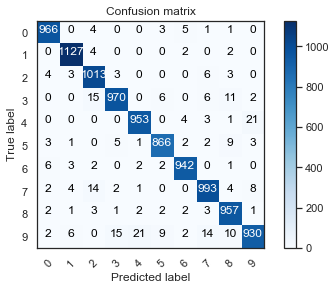

In [93]:
Y_pred = model.predict(x_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

Vemos que el modelo confunde los 9 con los 4 y los 3 principalmente

# <font color="#9E1B32">Ver algunos errores

In [94]:
errors = (Y_pred_classes - Y_true != 0)
Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
x_test_errors = x_test[errors]

In [109]:
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(12,8))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)),cmap='Greys')
            ax[row,col].set_title("El número predicho es :{}\nEl número real es :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

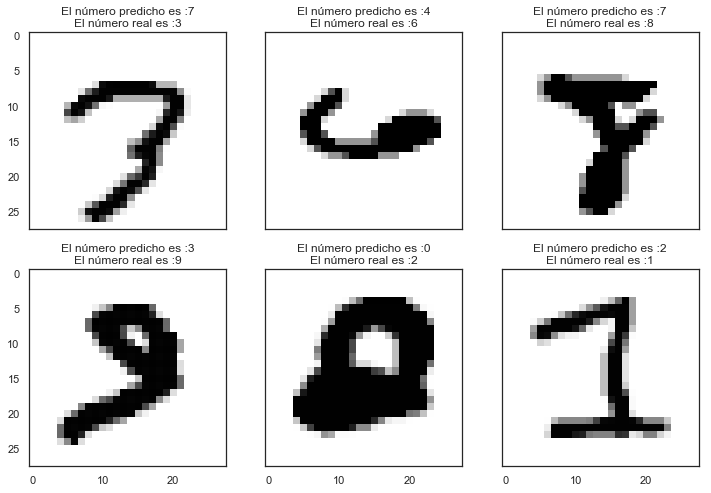

In [110]:
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
sorted_delta_errors = np.argsort(delta_pred_true_errors)
# Top 6 errores 
most_important_errors = sorted_delta_errors[-6:]
# Show the top 6 errores
display_errors(most_important_errors, x_test_errors, Y_pred_classes_errors, Y_true_errors)

# <font color="#9E1B32"><font color="#9E1B32">Shap. Model interpretability <a class="anchor" id="six"></a>

https://github.com/slundberg/shap

Interpretabilidad mediante los shap values. Estos marcarán, en la clase correspondiente, si cada pixel está ayudando o no a que la predicción sea esa clase. 
+ En rojo se marcan los pixeles con shap values positivos, implica que la probabilidad de que la predicción de esa clase sea mayor. Se marcan más las zonas que determinan la predicción final. 
+ En azul indica que los shap values son negativos. Esto es que estos píxeles hacen que la probabilidad de la predicción sea baja.  

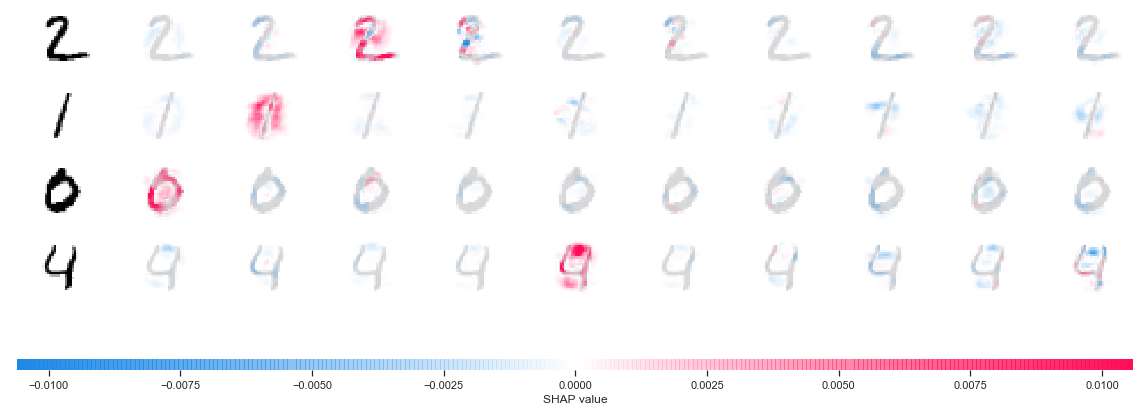

In [116]:
import shap
# select a set of background examples to take an expectation over. Elegimos 100
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(x_test[1:5])

# plot the feature attributions
shap.image_plot(shap_values, -x_test[1:5])

Observamos que el número 'dos' tiene zonas que indican que podria ser el número tres, pero otras zonas en azul niegan esa predicción. El número 4 tiene zonas de confusión con el 9. Pero los pixeles en blanco del cierre de arriba shap los pone en azul. Luego la clasificación final es un 4